In [1]:
# 1
import torch
from torch import nn,optim
from torch.autograd.variable import Variable
from torchvision import transforms,datasets
from utils import Logger
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [2]:
import pickle
import os,sys
import numpy as np
from baseline.AKE.ake import AKE
from baseline.Kriging.kriging import OrdryKriging
from baseline.NMF.nmf import NMF
from baseline.ST_MVL.st_mvl import ST_MVL

In [3]:
with open('../tensor2.pkl','rb') as f:
    tensor_array = np.array(pickle.load(f))

with open('../new_indices.pkl','rb') as f:
    new_indices = np.array(pickle.load(f))

with open('missing_pattern_data/1_missing_pattern.pkl','rb') as f:
    mask_list,result_list = pickle.load(f)
    
with open('1_output_list_st_mvl.pkl','rb') as f:
    output_list = pickle.load(f)
    
# with open('1_dcs_res_list.pkl','wb') as f:
#     pickle.dump(dcs_res_list,f)
    
with open('1_dcs_res_list2.pkl','rb') as f:
    dcs_res_list = pickle.load(f)

# with open('1_tensor_array_o.pkl','wb') as f:
#     pickle.dump(tensor_array_o,f)

with open('1_tensor_array_o.pkl','rb') as f:
    tensor_array_o = pickle.load(f)

In [4]:
# 5-3 4[128,256] 6.x
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 19*7
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(128, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden4(x)
        x = self.out(x)
        return x
    
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 19*7
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.LeakyReLU(0.2)
        )

        self.hidden1 = nn.Sequential(
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2)
        )
        
#         self.hidden2 = nn.Sequential(            
#             nn.Linear(256, 512),
#             nn.LeakyReLU(0.2)
#         )
        

        self.out = nn.Sequential(
            nn.Linear(256, n_out),
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
#         x = self.hidden2(x)
        x = self.out(x)
        return x

generator = torch.load('6_generator.pkl')
discriminator = torch.load('6_discriminator.pkl')

In [5]:
# new generate_missing_matrix with different pattern
def generate_missing_matrix(data_matrix,miss_ratio=0.1, pattern='MCAR', start_p='r'):
    origin  = data_matrix.copy()
    spatial_size = data_matrix.shape[0]
    temporal_size = data_matrix.shape[1]
    mask = np.ones_like(data_matrix)
    if pattern == 'MCAR':

        k = round(spatial_size*temporal_size*miss_ratio)
        ri = np.random.choice(spatial_size*temporal_size,k,replace=False)

    elif pattern == 'MAR':
        k = round(spatial_size*temporal_size*miss_ratio/2)
        ri1 = np.random.choice(spatial_size*temporal_size,k,replace=False)

        random_start = np.random.randint(0,temporal_size)
        ri2 = np.linspace(random_start,spatial_size*temporal_size-1,num=k)
        ri2 = ri2.astype(int)

        ri = np.append(ri1,ri2,0)
        # ri = ri2
        # print(ri1,ri2)
        # print(ri)

    elif pattern == "MNAR":
        if start_p == 'c':
            # constant start at #0
            k = round(spatial_size* temporal_size*miss_ratio)
            # ri = np.random.choice(spatial_size*temporal_size,k,replace=False)
            start = 0
            # print(k)
            # ri = np.arange(0,spatial_size*temporal_size,k-2)
            ri = np.linspace(0,spatial_size*temporal_size-1,num=k)
            ri = ri.astype(int)
            # print(ri)
            # print(ri.__len__())
        elif start_p == 'r':
             # random start at first row
            k = round(spatial_size* temporal_size*miss_ratio)
            # ri = np.random.choice(spatial_size*temporal_size,k,replace=False)
            start = 0
            # print(k)
            # ri = np.arange(0,spatial_size*temporal_size,k-2)
            random_start = np.random.randint(0,temporal_size)
            ri = np.linspace(random_start,spatial_size*temporal_size-1,num=k)
            ri = ri.astype(int)
            # print(ri)
            # print(ri.__len__())           pass
        else:
            raise NameError
    else:
        raise NameError
    origin.flat[ri] = 0
    mask.flat[ri] = 0
    return origin,mask
# data_matrix,mask =generate_missing_matrix(tensor_array[0],0.2,'MNAR','r')

In [6]:
# 3
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [7]:
#7-1
def reconstruction_gpu(data_matrix,mask):
#     print('step in')
    data_matrix_gpu = torch.tensor(data_matrix).cuda()
    mask_gpu = torch.tensor(mask).cuda()
#     print('init')
    
    times = 0
    min_mre = 9999
    min_g1_c = 0
    while True:
        g1 = generator(noise(8000))
        g1_c = g1.reshape(-1,19,7)
#         g1_c = g1.cpu().detach().numpy().reshape(80000,19,7)
#         del g1
        loss = g1_c * mask_gpu - data_matrix_gpu
#         print(loss.shape)
#         print(loss)
        loss = torch.abs(loss)
#         print(loss.shape)
#         print(loss)
        mre = torch.sum(loss,axis=1)
#         print(mre.shape)
#         print(mre)
        mre = torch.sum(mre,axis=1)
#         print(mre.shape)
#         print(mre)
#         print("min_mre:",np.min(mre))
        m_mre = torch.min(mre)
#         print(m_mre)
        loc = torch.where(mre == m_mre)[0][0]
#         print("loc:",loc)
#         print(g1_c[loc])
        g1_cpu = g1_c[loc].detach().cpu()
#         print(g1_cpu.is_cuda)
#         print(type(g1_cpu))
#         del g1_c
#         del g1
        torch.cuda.empty_cache()
#         print('cleared')
        times += 1
        if m_mre < min_mre:
            min_mre = m_mre
            min_g1_c = g1_cpu
        
        
        if m_mre < 60 or times > 10:
            break
    if m_mre < 60:
        return g1_cpu.numpy()
    else:
        return min_g1_c.numpy()
        
            
        
#         print(np.sum(np.abs(loss)))
        
#         min_mre = np.
#         for g1_i in g1_c:
#             loss = g1_i*mask - data_matrix
#             mre = np.sum(np.abs(loss))
#             times += 1

#             if mre < min_mre:
#                 min_mre = mre
#                 min_g1_c = g1_c

#             if mre < 60 or times > 40000: #40000
#             # if mre < 60:
#                 break
# #             min_mre = mre
# #             re_data_matrix = j
# #     print(min_mre)
#     if mre < 60:
#         return g1_c
#     else:
        
#         return min_g1_c
data_matrix,mask =generate_missing_matrix(tensor_array[1000],0.1)
re_data = reconstruction_gpu(data_matrix,mask)

In [8]:
def get_distance_matrix(data_matrix,linear=False):
    if not linear:
        spatial_length = data_matrix.shape[0]
        # print(spatial_length)
        dis_matrix = np.random.rand(spatial_length,spatial_length)
        dis_matrix += dis_matrix.T
        np.fill_diagonal(dis_matrix,0)
        return dis_matrix
    else:
        spatial_length = data_matrix.shape[0]
        dis_matrix = np.zeros((spatial_length,spatial_length))
        for i in range(spatial_length):
            dis_matrix[i][i:] = np.arange(0,spatial_length-i)
        dis_matrix = dis_matrix + dis_matrix.T
        return dis_matrix

In [9]:
def loss_compute(origin_data,re_data,mask):
    return np.sum(np.abs((re_data-origin_data)*(1-mask)))

print(loss_compute(tensor_array[15000],re_data,mask))

204.08757534480097


In [10]:
class PatternDiscriminator(torch.nn.Module):

    def __init__(self):
        super(PatternDiscriminator,self).__init__()
        n_features=19*7
        n_out = 1

        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden3 = nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(128, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.out(x)
        return x
    
p_discriminator = torch.load('1_pd3.pkl')

In [11]:
# from multiprocessing import Pool
# import multiprocessing as mp

# manager = mp.Manager()

# def compute(missing_ratio,pattern):
#     with open('../tensor2.pkl','rb') as f:
#         tensor_array = np.array(pickle.load(f))
#     data_matrix_list = []
#     mask_list = []
#     ds_list = []
#     res_list = []
#     for tensor in tensor_array:
#         data_matrix,mask = generate_missing_matrix(tensor,missing_ratio,pattern,'r')
#         ds = get_distance_matrix(data_matrix,True)
#         data_matrix_list.append(data_matrix)
#         mask_list.append(mask)
#         ds_list.append(ds)
#         st_mvl = ST_MVL()
#         res_list.append(st_mvl.predict(data_matrix,ds))
#     print('done_{}_{}'.format(missing_ratio,pattern))
#     return (data_matrix_list,mask_list,ds_list,res_list,'{}_{}'.format(missing_ratio,pattern))

# results = []
# p = Pool(16)

# for i in range(1,10):
#     for pattern in ['MCAR','MAR','MNAR']:
#         result = p.apply_async(func=compute,args=(0.1*i,pattern))
#         results.append(result)
# p.close()
# p.join()

# output_list = []
# for result in results:
#     output_list.append(result.get())

In [12]:
#
#with open('1_output_list_st_mvl.pkl','wb') as f:
#    pickle.dump(output_list,f)

In [13]:
# with open('1_output_list_st_mvl.pkl','rb') as f:
#     output_list = pickle.load(f)

In [14]:
# with open('1_tensor_array_o.pkl','wb') as f:
#     pickle.dump(tensor_array_o,f)

# with open('1_tensor_array_o.pkl','rb') as f:
#     tensor_array_o = pickle.load(f)

In [15]:
data_matrix_list = []
mask_list = []
res_list = []
# data_matrix_list, mask_list, ds_list, res_list,'{}_{}'


for i in output_list:
    data_matrix_list.extend(i[0])
    mask_list.extend(i[1])
    res_list.extend(i[3])
print(len(data_matrix_list))

data_matrix_array = np.array(data_matrix_list)#.reshape(-1,133)
mask_array = np.array(mask_list)#.reshape(-1,133)
res_array = np.array(res_list).reshape(-1,133)

807246


In [16]:
data_matrix_copy = data_matrix_array.flatten()

In [17]:
data_matrix_copy[np.where(np.isnan(data_matrix_copy) == True)[0]] = 0

In [18]:
data_matrix_array1 = data_matrix_copy.reshape(-1,19,7)
print(data_matrix_array1.shape)

(807246, 19, 7)


In [19]:
np.where(np.isnan(data_matrix_array1 ) == True)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [20]:
# dcs_res_list = []
# for i,j in enumerate(data_matrix_array):
#     print(i)
#     dcs_res = reconstruction_gpu(data_matrix_array[i],mask_array[i])
#     dcs_res_list.append(dcs_res)

In [21]:
# with open('1_dcs_res_list2.pkl','wb') as f:
#     pickle.dump(dcs_res_list,f)

In [22]:
print(data_matrix_array.shape)
print(mask_array.shape)
print(res_array.shape)

(807246, 19, 7)
(807246, 19, 7)
(807246, 133)


In [23]:
# tensor_array_o = np.array(tensor_list_o).reshape(-1,133)
print(tensor_array_o.shape)

(807246, 133)


In [32]:
# data_matrix_tensor = torch.tensor(data_matrix_array1,dtype=torch.float32).cuda()

# result_tensor = torch.tensor(tensor_array_o[:400000],dtype=torch.float32).cuda()
# mvl_mask_tensor  = torch.tensor(mask_array.reshape(-1,133)[:400000],dtype=torch.float32).cuda()
# mvl_result_tensor = torch.tensor(res_array[:400000],dtype=torch.float32).cuda()
# dcs_result_tensor = torch.tensor(np.array(dcs_res_list).reshape(-1,133)[:400000],dtype=torch.float32).cuda()

result_tensor = torch.tensor(tensor_array_o[400000:],dtype=torch.float32).cuda()
mvl_mask_tensor  = torch.tensor(mask_array.reshape(-1,133)[400000:],dtype=torch.float32).cuda()
mvl_result_tensor = torch.tensor(res_array[400000:],dtype=torch.float32).cuda()
dcs_result_tensor = torch.tensor(np.array(dcs_res_list).reshape(-1,133)[400000:],dtype=torch.float32).cuda()

In [33]:
# print(data_matrix_tensor.shape)
print(result_tensor.shape)
print(mvl_mask_tensor.shape)
print(mvl_result_tensor.shape)
print(dcs_result_tensor.shape)

torch.Size([407246, 133])
torch.Size([407246, 133])
torch.Size([407246, 133])
torch.Size([407246, 133])


In [ ]:
dcs_loss = []
mvl_loss = []
new_loss = []

for tensor in tensor_array[:500]:
    
    data_matrix,mask =generate_missing_matrix(tensor,0.5,'MNAR')
    re_data = reconstruction_gpu(data_matrix,mask)

    stmvl = ST_MVL()

    ds = get_distance_matrix(data_matrix,True)

    re_mvl = stmvl.predict(data_matrix,ds)

    m_tensor1 = torch.tensor(mask.reshape(-1,133),dtype=torch.float32).cuda()

    p_d = p_discriminator(m_tensor1).detach().cpu().numpy()

    re_new = p_d*re_data+(1-p_d)*re_mvl
    
    dcs_loss.append(loss_compute(tensor,re_data,mask)/133)
    mvl_loss.append(loss_compute(tensor,re_mvl,mask)/133)
    new_loss.append(loss_compute(tensor,re_new,mask)/133)



def loss_compute(origin_data,re_data,mask):
    return np.sum(np.abs((re_data-origin_data)*(1-mask)))

# print(loss_compute(tensor_array[1100],re_data,mask))
# print(loss_compute(tensor_array[1100],re_mvl,mask))
# print(loss_compute(tensor_array[1100],re_new,mask))

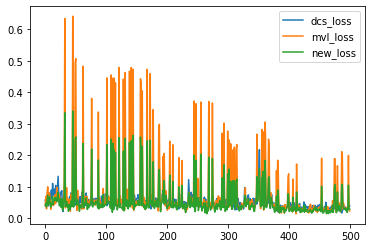

In [14]:
# 0.1 MCAR
plt.plot(dcs_loss,label='dcs_loss')
plt.plot(mvl_loss,label='mvl_loss')
plt.plot(new_loss,label='new_loss')
plt.legend()

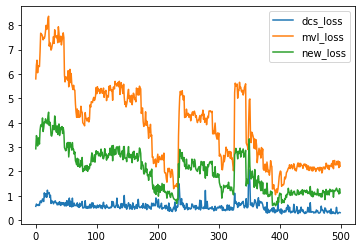

In [12]:
# 0.9 MCAR
plt.plot(dcs_loss,label='dcs_loss')
plt.plot(mvl_loss,label='mvl_loss')
plt.plot(new_loss,label='new_loss')
plt.legend()

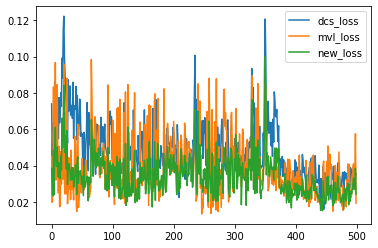

In [30]:
# 0.1 MNAR
plt.plot(dcs_loss,label='dcs_loss')
plt.plot(mvl_loss,label='mvl_loss')
plt.plot(new_loss,label='new_loss')
plt.legend()

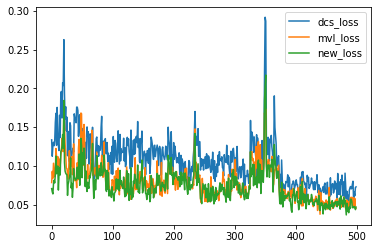

In [16]:
# 0.2 MNAR
plt.plot(dcs_loss,label='dcs_loss')
plt.plot(mvl_loss,label='mvl_loss')
plt.plot(new_loss,label='new_loss')
plt.legend()

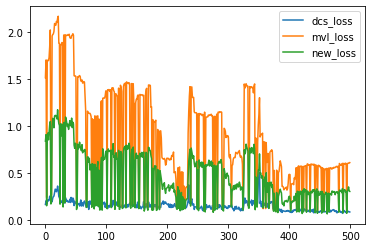

In [18]:
# 0.3 MNAR
plt.plot(dcs_loss,label='dcs_loss')
plt.plot(mvl_loss,label='mvl_loss')
plt.plot(new_loss,label='new_loss')
plt.legend()

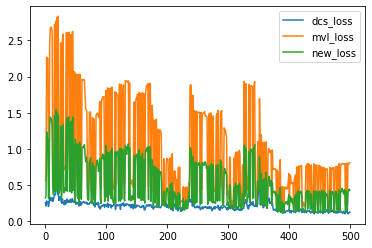

In [34]:
# 0.4 MNAR
plt.plot(dcs_loss,label='dcs_loss')
plt.plot(mvl_loss,label='mvl_loss')
plt.plot(new_loss,label='new_loss')
plt.legend()

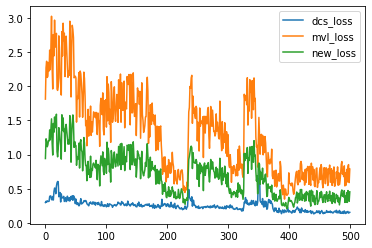

In [28]:
# 0.5 MNAR
plt.plot(dcs_loss,label='dcs_loss')
plt.plot(mvl_loss,label='mvl_loss')
plt.plot(new_loss,label='new_loss')
plt.legend()

In [35]:
# torch.save('1_pd.pt',p_discriminator)
torch.save(p_discriminator,'1_pd2.pkl')

In [26]:
p_discriminator = PatternDiscriminator().cuda()
d_optimizer = optim.Adam(discriminator.parameters(),lr=0.0002)
    
# loss = nn.BCELoss()
loss = nn.MSELoss()

d_steps=1
num_epoch=400


def train_d(optimizer,result_tensor,dcs_res,mvl_res, mask):

    optimizer.zero_grad()
    
#     print(result_tensor.shape)
#     print(dcs_res.shape)
#     print(mvl_res.shape)
#     print(mask.shape)
    
#     dcs_res = reconstruction_gpu(data_matrix,mask)
    
#     ds = get_distance_matrix(data_matrix,True)
    
#     mvl_res = stmvl.predict(data_matrix,ds)
    
    p_d = p_discriminator(mask)
    
#     print(p_d.shape)

    prediction = p_d*dcs_res+(1-p_d)*mvl_res
    
#     print(prediction.shape)
    
    error = loss(prediction,result_tensor)
    error.backward()

    optimizer.step()

    return error, prediction

In [27]:
len(dcs_res_list)

807246

In [34]:
for epoch in range(num_epoch*10):
#     error = train_d(d_optimizer,result_tensor,data_matrix_tensor,mvl_mask_tensor,mvl_result_tensor)
    error = train_d(d_optimizer,result_tensor,dcs_result_tensor,mvl_result_tensor,mvl_mask_tensor)

In [29]:
# 3
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n